In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [45]:
# rest_available = [11,12,50,51]
rest_available = [10,11,12,13,17,18,49,50,51,52,53,54]

In [5]:
num_seg = len(rest_available)+1

In [6]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [7]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [8]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
#        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im)
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [9]:
file_names = pd.read_csv("all_complete_path.csv")

In [10]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [11]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [12]:
277*18

4986

In [13]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:4986]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [14]:
cd = True
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 16
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [15]:
data = next(iter(dataloader['train']))

In [16]:
data['x'].size()

torch.Size([16, 3, 256, 256])

In [17]:
list_arr = []
for data in dataloader["train"]:
    y = data['y'].numpy()
    N,C,_,_ = y.shape
    sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
    list_arr.append(sum_arr)
final_arr = np.concatenate(list_arr,axis = 0)
pickling(final_arr,'wt_13_class.p')

In [69]:
# sum_pix = [[] for _ in range(num_seg)]
# for data in dataloader["train"]:
#     y = data['y'].numpy()
#     #print(y.shape)
#     for j in range(len(rest_available)):
#         for i in range(bs):
#             try:
#                 s = np.sum(y[i,j,:,:])
#                 sum_pix[j].append(s)
#             except:
#                 continue
#         sum_pix.append(temp)
# pickling(sum_pix,'wt_3_class.p')

In [70]:
# sum_pix = unpickling('wt_3_class.p')

In [71]:
# sum_pixel = np.array(sum_pix)

In [17]:
final_arr = unpickling('wt_13_class.p')

In [18]:
final_arr.shape

(4986, 13)

In [19]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [20]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [21]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [23]:
mask = (final_arr[:,-1]!=(256.0 *256.0))

In [24]:
wts_num = np.mean(final_arr[mask,:],axis=0)

In [120]:
wts_num[1] = 25.0
wts_num[-1] = 256.0 * 256.0 - np.sum(wts_num[:-1])

In [25]:
wts = []
for i in range(final_arr.shape[1] - 1):
    temp_mask = final_arr[:,i]!= 0
    temp_wt = np.mean(final_arr[temp_mask,i])
    wts.append(temp_wt)
zero_wt = 256.0 * 256.0 - np.sum(wts)
wts.append(zero_wt)
wts_num = np.array(wts)

In [26]:
wts_num

array([  360.7510376 ,   123.98397064,   202.32743835,    86.93437195,
         142.98973083,    92.06100464,   336.12231445,   131.78224182,
         210.96920776,    99.37754822,   140.318573  ,    92.00252533,
       63516.37988281])

In [26]:
wts_num

array([1.65870392e+02, 7.31939468e+01, 1.08150429e+02, 2.63188267e+01,
       9.22601700e+01, 3.28353844e+01, 1.48186371e+02, 7.44314117e+01,
       1.10175026e+02, 2.76414375e+01, 9.29262085e+01, 3.44683075e+01,
       6.45495547e+04], dtype=float32)

In [29]:
wts_num

array([1.03082855e+02, 1.40807144e+02, 3.73557129e+01, 1.03620003e+02,
       1.45429993e+02, 3.72000008e+01, 6.49685156e+04], dtype=float32)

In [30]:
# wts_num = np.array([1e-6,1.0])

In [27]:
wts_torch = Variable(torch.from_numpy(np.array(wts_num))).cuda()

In [28]:
# count = 0
# count_total = 0
# for data in dataloader['train']:
#     y = data['y']
#     y_mask = torch.sum((torch.sum(y[:,0,:,:].contiguous().view(8,-1),dim = 1) != 0).type(torch.FloatTensor))
#     count += y_mask
#     count_total += 8
# print(count/count_total)

In [29]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    N, C, sh1, sh2 = true.size()
    
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
    mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [30]:
def dice_score(true,scores, epsilon = 1e-7):
#     N ,C, sh1, sh2 = true1.size()
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [31]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
#                 rand_num = np.random.rand()
#                 if rand_num < 0.8:
                y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                y = y[y_mask]
                x = x[y_mask]
#                 for sel in range(x.size()[0]):
#                     if torch.sum(y[sel,0,:,:]) != 0:
#                         y_sel.append(y[sel,:,:,:])
#                         x_sel.append(x[sel,:,:,:])

#                 try:
#                     y_sel = torch.stack(y_sel)
#                     output_sel = torch.stack(output_sel)
#                 except:
#                     continue
#                 output = model(x)
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                #loss = Variable(dice_loss_2(y_sel, output_sel,wts_torch),requires_grad=True)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)

                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
#                 epoch_score = 0
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
    #                 epoch_score += dice_scores_of_all_class[j][phase][-1]
    #             epoch_score_av = epoch_score / (num_seg - 1)
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
        #print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [32]:
model = Unet(in_chan = 3,out_chan = num_seg).cuda()
model.apply(weights_init)
model = nn.DataParallel(model)
criterion = dice_loss_2
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [51]:
optimizer = optim.Adam(model.parameters(),lr = 7e-6)

In [55]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'13_seg_model_2',num_seg = num_seg, num_epochs = 60,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.1053, Av. Dice Score: 0.9197
Class 0 (DS): 0.9132
Class 1 (DS): 0.9242
Class 2 (DS): 0.9096
Class 3 (DS): 0.8942
Class 4 (DS): 0.9135
Class 5 (DS): 0.9527
Class 6 (DS): 0.9253
Class 7 (DS): 0.9217
Class 8 (DS): 0.9124
Class 9 (DS): 0.9054
Class 10 (DS): 0.9106
Class 11 (DS): 0.9540
----------
Epoch: 0, Phase: validate, epoch loss: 0.1828, Av. Dice Score: 0.8915
Class 0 (DS): 0.9136
Class 1 (DS): 0.9193
Class 2 (DS): 0.8859
Class 3 (DS): 0.8323
Class 4 (DS): 0.8755
Class 5 (DS): 0.9214
Class 6 (DS): 0.9040
Class 7 (DS): 0.8825
Class 8 (DS): 0.9041
Class 9 (DS): 0.8824
Class 10 (DS): 0.8681
Class 11 (DS): 0.9085
----------
Epoch: 1, Phase: train, epoch loss: 0.1090, Av. Dice Score: 0.9196
Class 0 (DS): 0.9182
Class 1 (DS): 0.9230
Class 2 (DS): 0.9129
Class 3 (DS): 0.8894
Class 4 (DS): 0.9167
Class 5 (DS): 0.9509
Class 6 (DS): 0.9229
Class 7 (DS): 0.9141
Class 8 (DS): 0.9192
Class 9 (DS): 0.9048
Class 10 (DS): 0.9111
Class 11 (DS): 0.9516
----------
E

Epoch: 13, Phase: validate, epoch loss: 0.1793, Av. Dice Score: 0.8946
Class 0 (DS): 0.9075
Class 1 (DS): 0.9049
Class 2 (DS): 0.8875
Class 3 (DS): 0.8465
Class 4 (DS): 0.8693
Class 5 (DS): 0.9264
Class 6 (DS): 0.9144
Class 7 (DS): 0.8963
Class 8 (DS): 0.9111
Class 9 (DS): 0.9008
Class 10 (DS): 0.8738
Class 11 (DS): 0.8967
----------
Epoch: 14, Phase: train, epoch loss: 0.1061, Av. Dice Score: 0.9207
Class 0 (DS): 0.9100
Class 1 (DS): 0.9244
Class 2 (DS): 0.9158
Class 3 (DS): 0.8958
Class 4 (DS): 0.9161
Class 5 (DS): 0.9502
Class 6 (DS): 0.9273
Class 7 (DS): 0.9287
Class 8 (DS): 0.9165
Class 9 (DS): 0.9039
Class 10 (DS): 0.9087
Class 11 (DS): 0.9514
----------
Epoch: 14, Phase: validate, epoch loss: 0.1656, Av. Dice Score: 0.8941
Class 0 (DS): 0.9141
Class 1 (DS): 0.9247
Class 2 (DS): 0.8860
Class 3 (DS): 0.8396
Class 4 (DS): 0.8851
Class 5 (DS): 0.9023
Class 6 (DS): 0.9197
Class 7 (DS): 0.9001
Class 8 (DS): 0.9156
Class 9 (DS): 0.8898
Class 10 (DS): 0.8592
Class 11 (DS): 0.8924
------

Epoch: 26, Phase: train, epoch loss: 0.1027, Av. Dice Score: 0.9198
Class 0 (DS): 0.9046
Class 1 (DS): 0.9288
Class 2 (DS): 0.9134
Class 3 (DS): 0.8959
Class 4 (DS): 0.9124
Class 5 (DS): 0.9484
Class 6 (DS): 0.9220
Class 7 (DS): 0.9300
Class 8 (DS): 0.9095
Class 9 (DS): 0.9103
Class 10 (DS): 0.9099
Class 11 (DS): 0.9519
----------
Epoch: 26, Phase: validate, epoch loss: 0.1724, Av. Dice Score: 0.8916
Class 0 (DS): 0.9183
Class 1 (DS): 0.9102
Class 2 (DS): 0.8762
Class 3 (DS): 0.8277
Class 4 (DS): 0.8856
Class 5 (DS): 0.9262
Class 6 (DS): 0.9147
Class 7 (DS): 0.8845
Class 8 (DS): 0.9025
Class 9 (DS): 0.8866
Class 10 (DS): 0.8615
Class 11 (DS): 0.9049
----------
Epoch: 27, Phase: train, epoch loss: 0.1028, Av. Dice Score: 0.9220
Class 0 (DS): 0.9174
Class 1 (DS): 0.9232
Class 2 (DS): 0.9163
Class 3 (DS): 0.8949
Class 4 (DS): 0.9158
Class 5 (DS): 0.9480
Class 6 (DS): 0.9228
Class 7 (DS): 0.9215
Class 8 (DS): 0.9200
Class 9 (DS): 0.9139
Class 10 (DS): 0.9140
Class 11 (DS): 0.9560
---------

Epoch: 38, Phase: validate, epoch loss: 0.1644, Av. Dice Score: 0.8943
Class 0 (DS): 0.9135
Class 1 (DS): 0.9190
Class 2 (DS): 0.8631
Class 3 (DS): 0.8378
Class 4 (DS): 0.8841
Class 5 (DS): 0.9230
Class 6 (DS): 0.9232
Class 7 (DS): 0.9006
Class 8 (DS): 0.9054
Class 9 (DS): 0.8806
Class 10 (DS): 0.8667
Class 11 (DS): 0.9143
----------
Epoch: 39, Phase: train, epoch loss: 0.0995, Av. Dice Score: 0.9233
Class 0 (DS): 0.9135
Class 1 (DS): 0.9284
Class 2 (DS): 0.9191
Class 3 (DS): 0.8956
Class 4 (DS): 0.9188
Class 5 (DS): 0.9542
Class 6 (DS): 0.9311
Class 7 (DS): 0.9284
Class 8 (DS): 0.9185
Class 9 (DS): 0.9030
Class 10 (DS): 0.9147
Class 11 (DS): 0.9544
----------
Epoch: 39, Phase: validate, epoch loss: 0.1697, Av. Dice Score: 0.8939
Class 0 (DS): 0.9190
Class 1 (DS): 0.9229
Class 2 (DS): 0.8689
Class 3 (DS): 0.8354
Class 4 (DS): 0.8775
Class 5 (DS): 0.9118
Class 6 (DS): 0.9281
Class 7 (DS): 0.8973
Class 8 (DS): 0.9049
Class 9 (DS): 0.9006
Class 10 (DS): 0.8613
Class 11 (DS): 0.8991
------

Epoch: 51, Phase: train, epoch loss: 0.0994, Av. Dice Score: 0.9241
Class 0 (DS): 0.9119
Class 1 (DS): 0.9298
Class 2 (DS): 0.9152
Class 3 (DS): 0.8963
Class 4 (DS): 0.9158
Class 5 (DS): 0.9573
Class 6 (DS): 0.9234
Class 7 (DS): 0.9296
Class 8 (DS): 0.9237
Class 9 (DS): 0.9123
Class 10 (DS): 0.9146
Class 11 (DS): 0.9593
----------
Epoch: 51, Phase: validate, epoch loss: 0.1655, Av. Dice Score: 0.8905
Class 0 (DS): 0.9155
Class 1 (DS): 0.9118
Class 2 (DS): 0.8669
Class 3 (DS): 0.8154
Class 4 (DS): 0.8672
Class 5 (DS): 0.9240
Class 6 (DS): 0.9192
Class 7 (DS): 0.8992
Class 8 (DS): 0.8961
Class 9 (DS): 0.9003
Class 10 (DS): 0.8727
Class 11 (DS): 0.8983
----------
Epoch: 52, Phase: train, epoch loss: 0.0974, Av. Dice Score: 0.9248
Class 0 (DS): 0.9122
Class 1 (DS): 0.9297
Class 2 (DS): 0.9179
Class 3 (DS): 0.9014
Class 4 (DS): 0.9252
Class 5 (DS): 0.9536
Class 6 (DS): 0.9309
Class 7 (DS): 0.9305
Class 8 (DS): 0.9188
Class 9 (DS): 0.9059
Class 10 (DS): 0.9150
Class 11 (DS): 0.9571
---------

In [53]:
pickling(loss_hist, 'Loss_hist_13_seg_2.p')

In [54]:
pickling(dice_hist, 'Dice_hist_13_seg_2.p')

In [41]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [42]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [43]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    output = model(x)
    for i in range(bs):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.unsqueeze(1)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


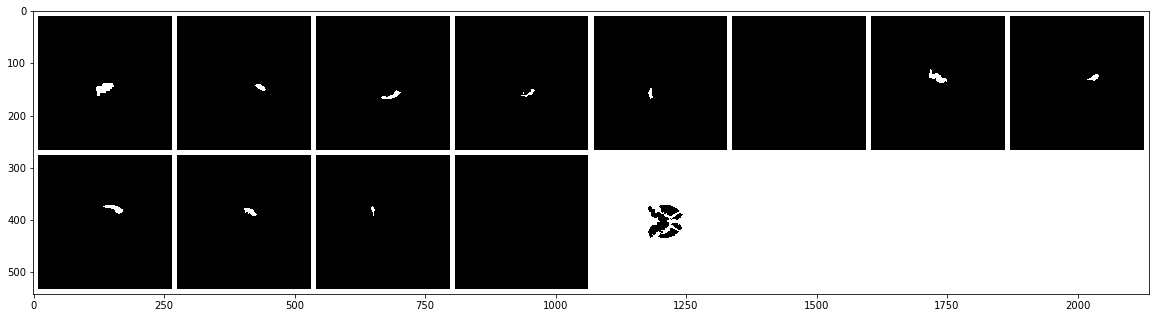

----------------------------------------------------------------------------------------------------
Prediction


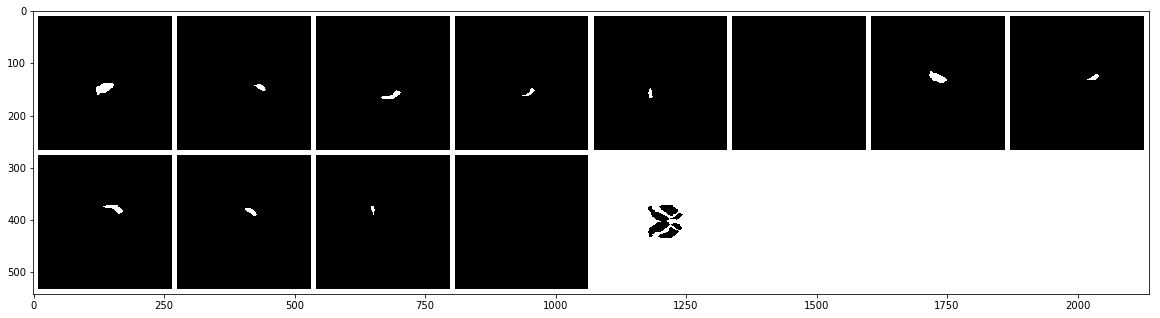

----------------------------------------------------------------------------------------------------
Ground Truth


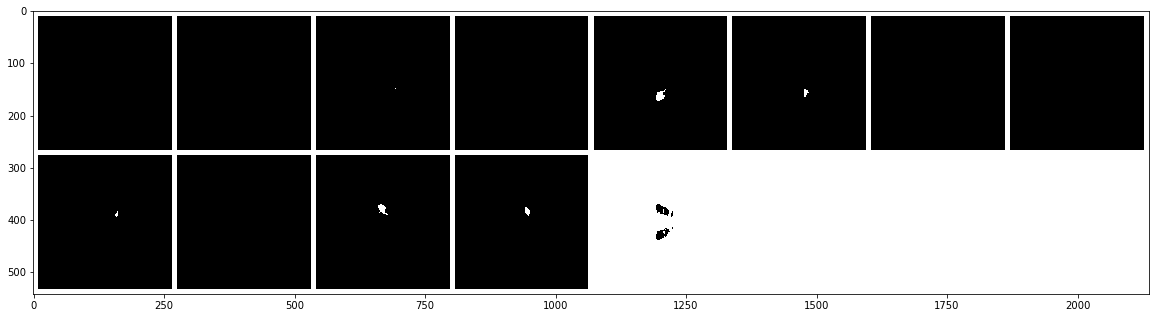

----------------------------------------------------------------------------------------------------
Prediction


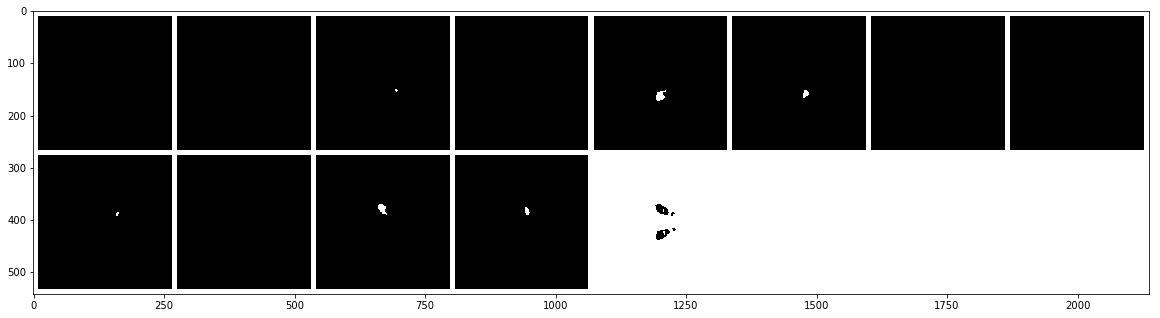

----------------------------------------------------------------------------------------------------
Ground Truth


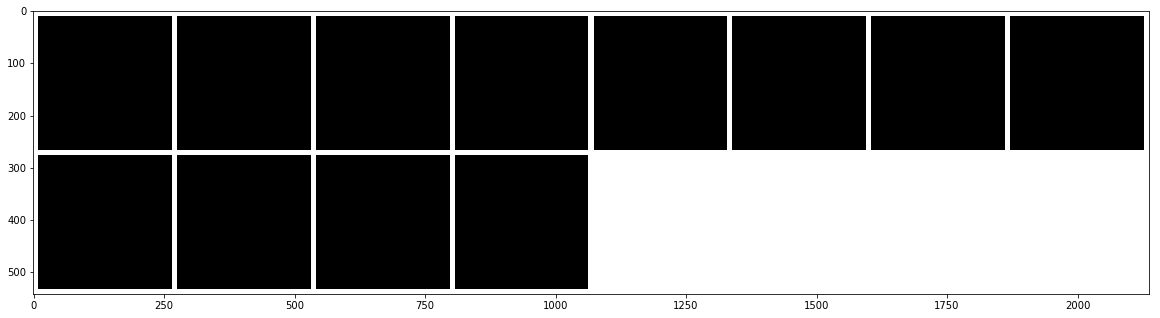

----------------------------------------------------------------------------------------------------
Prediction


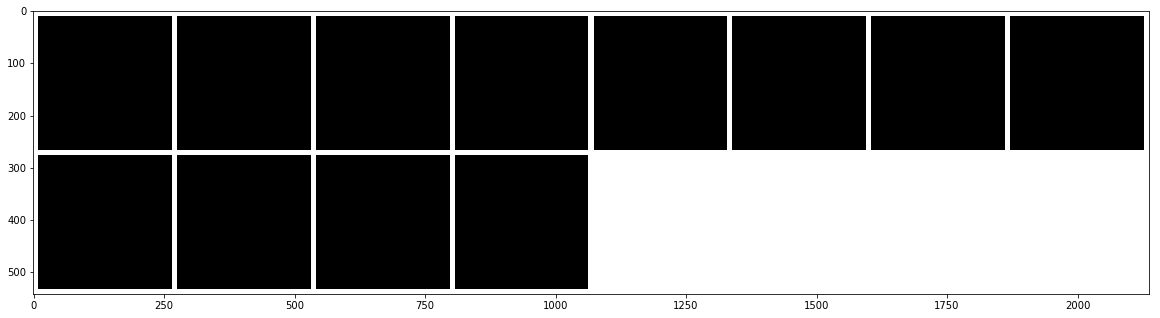

----------------------------------------------------------------------------------------------------
Ground Truth


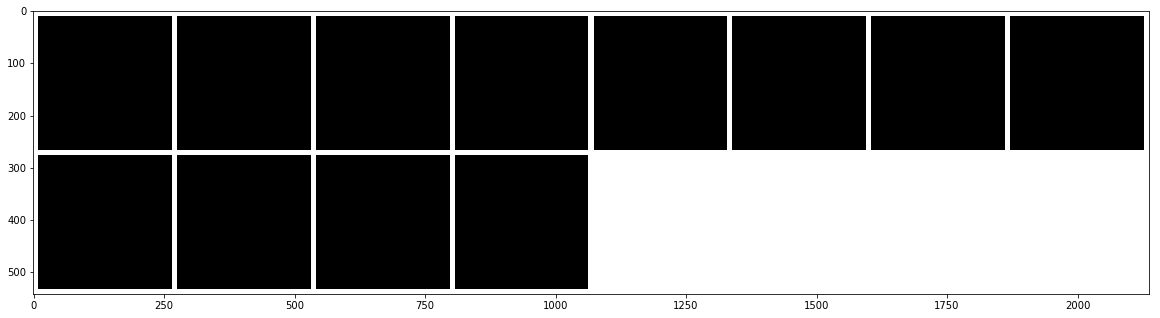

----------------------------------------------------------------------------------------------------
Prediction


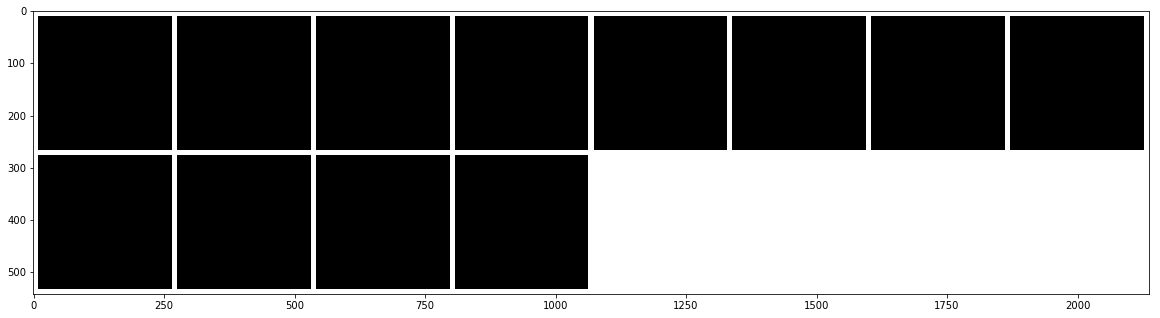

----------------------------------------------------------------------------------------------------
Ground Truth


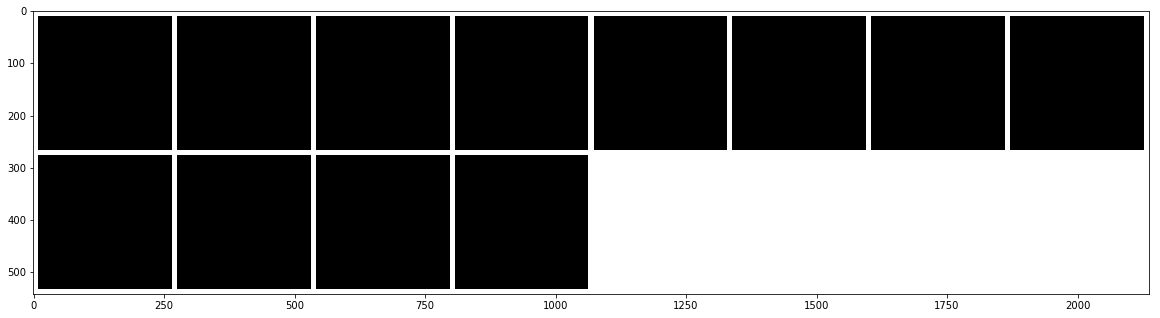

----------------------------------------------------------------------------------------------------
Prediction


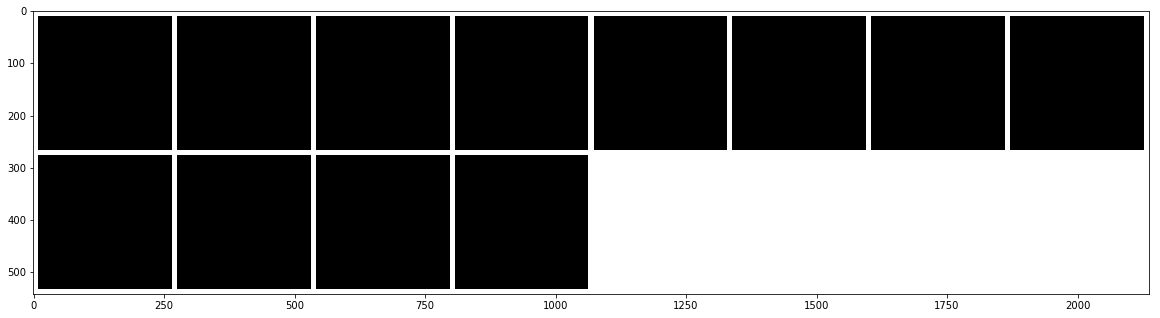

----------------------------------------------------------------------------------------------------
Ground Truth


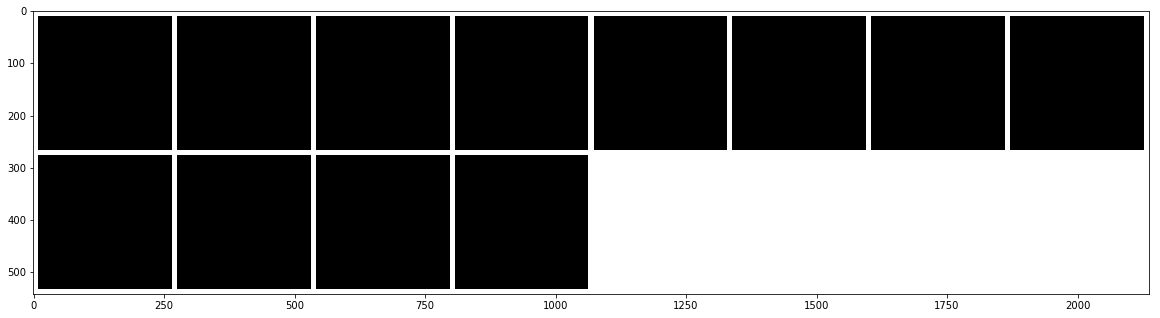

----------------------------------------------------------------------------------------------------
Prediction


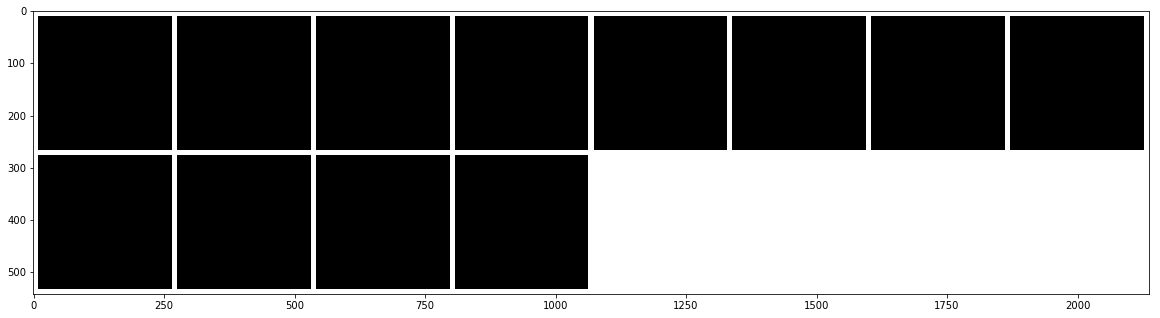

----------------------------------------------------------------------------------------------------
Ground Truth


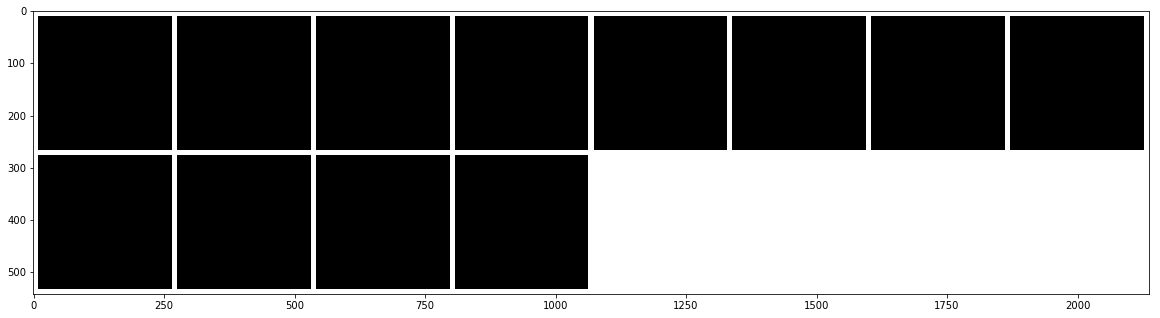

----------------------------------------------------------------------------------------------------
Prediction


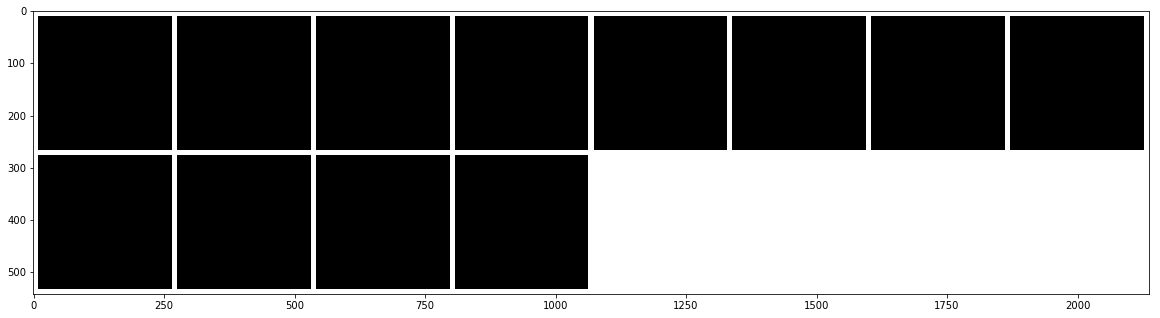

----------------------------------------------------------------------------------------------------
Ground Truth


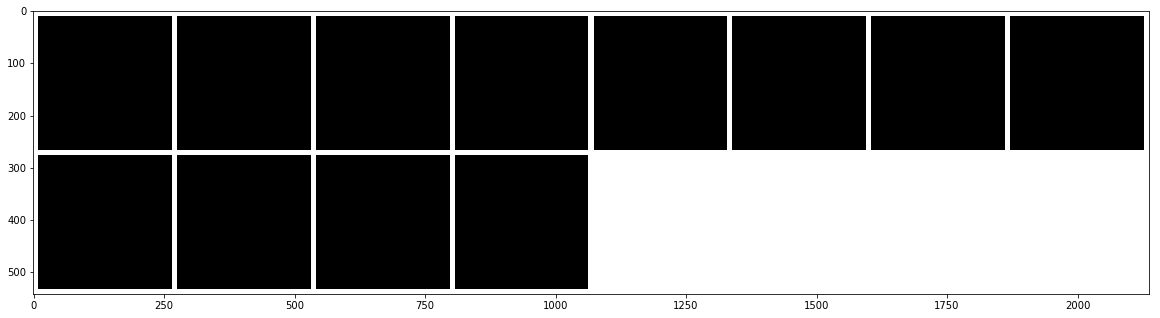

----------------------------------------------------------------------------------------------------
Prediction


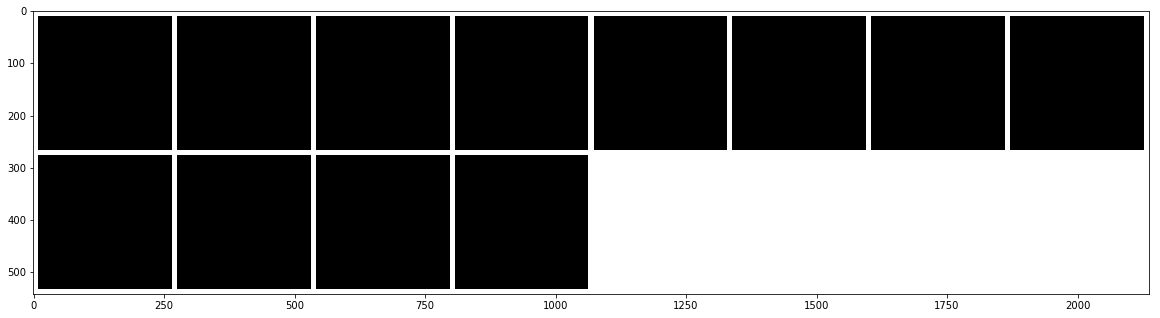

----------------------------------------------------------------------------------------------------
Ground Truth


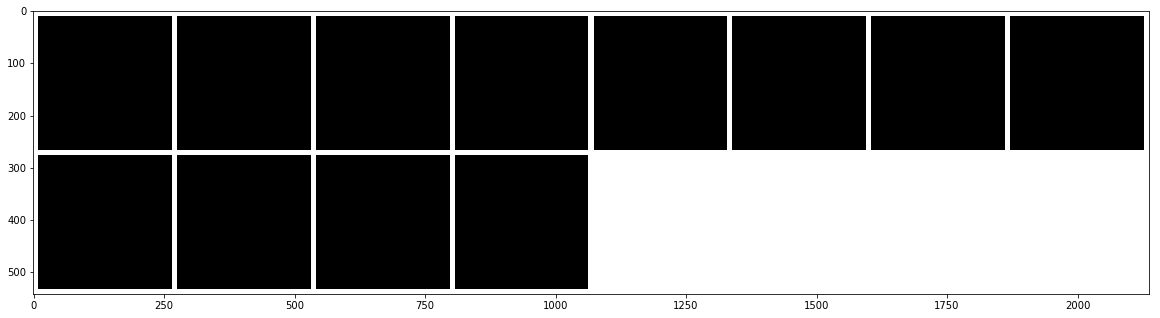

----------------------------------------------------------------------------------------------------
Prediction


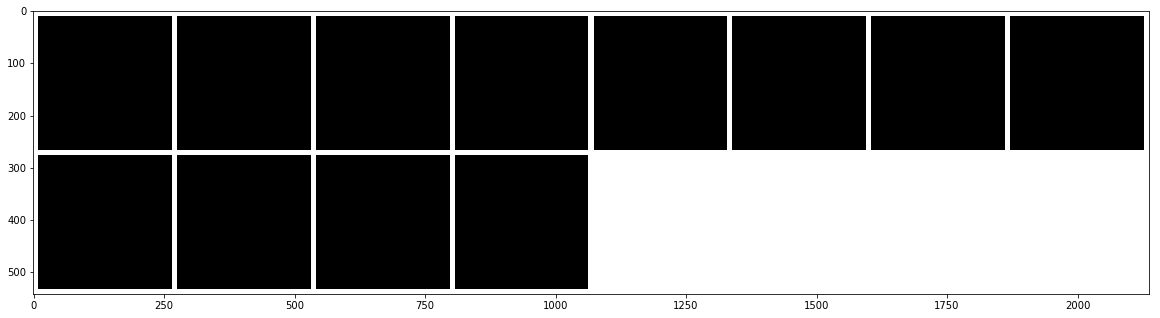

----------------------------------------------------------------------------------------------------
Ground Truth


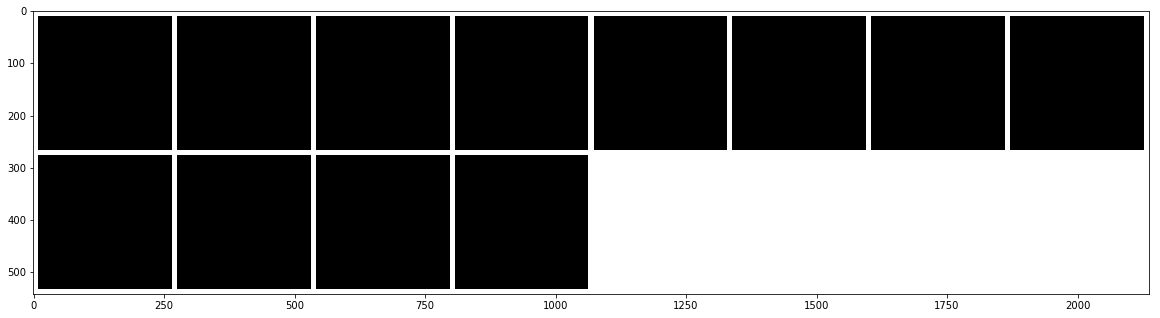

----------------------------------------------------------------------------------------------------
Prediction


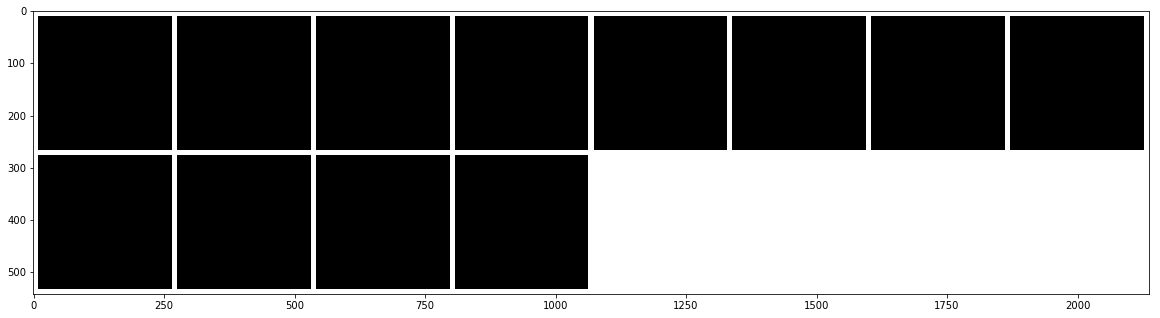

----------------------------------------------------------------------------------------------------
Ground Truth


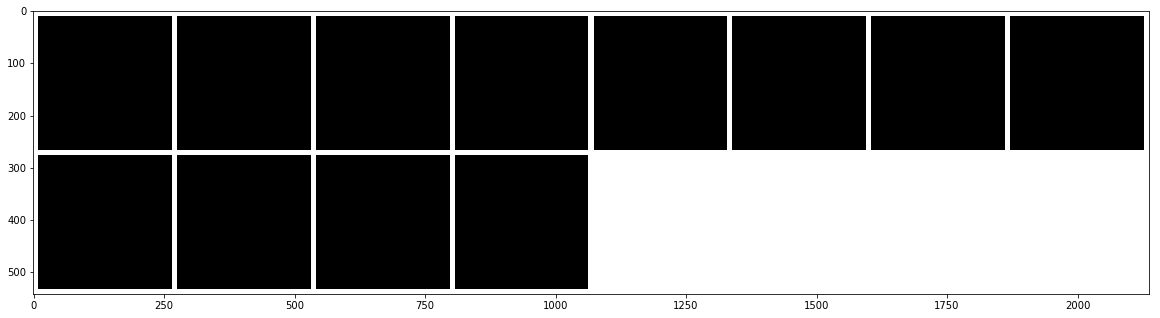

----------------------------------------------------------------------------------------------------
Prediction


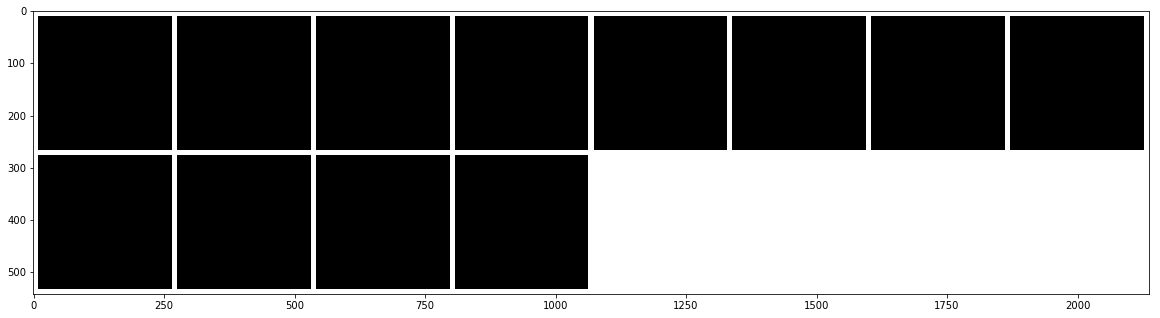

----------------------------------------------------------------------------------------------------
Ground Truth


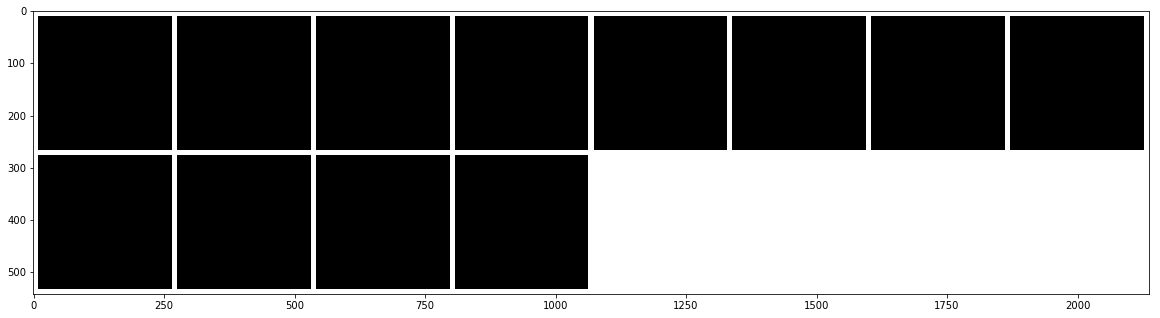

----------------------------------------------------------------------------------------------------
Prediction


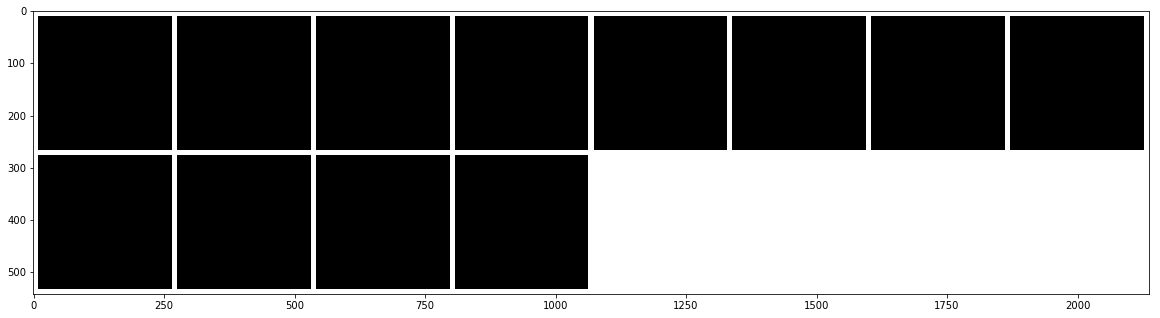

----------------------------------------------------------------------------------------------------
Ground Truth


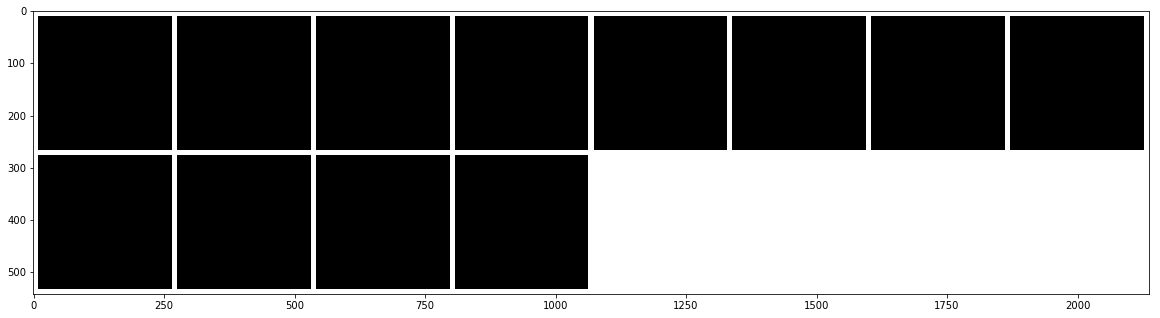

----------------------------------------------------------------------------------------------------
Prediction


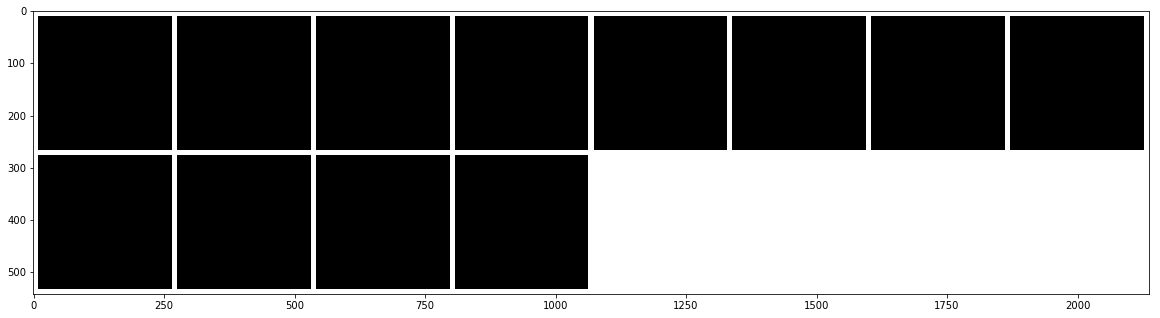

----------------------------------------------------------------------------------------------------
Ground Truth


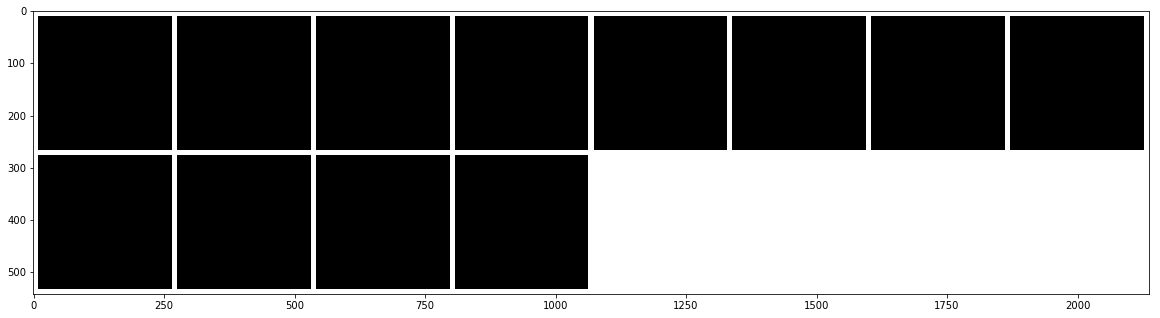

----------------------------------------------------------------------------------------------------
Prediction


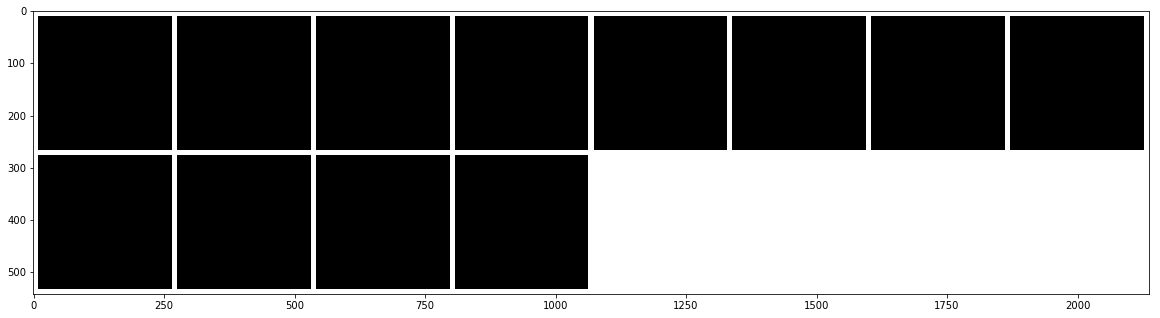

----------------------------------------------------------------------------------------------------
Ground Truth


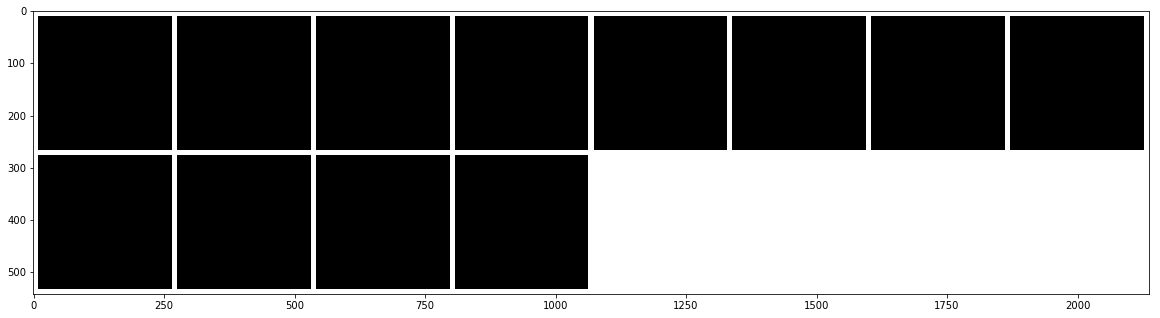

----------------------------------------------------------------------------------------------------
Prediction


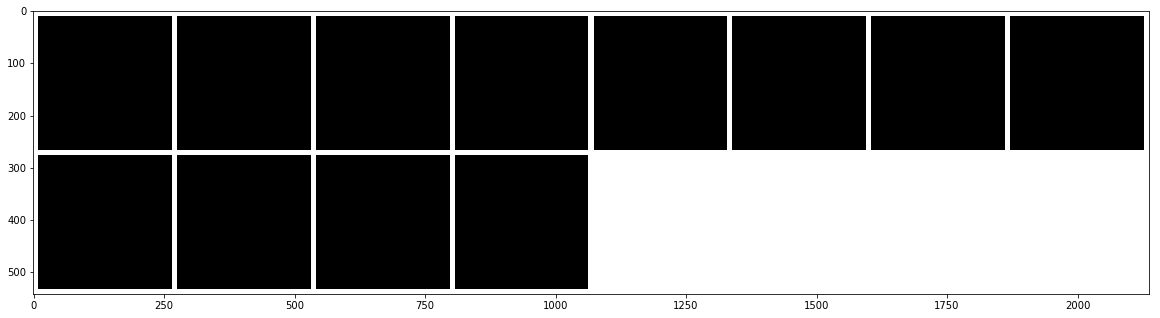

----------------------------------------------------------------------------------------------------
Ground Truth


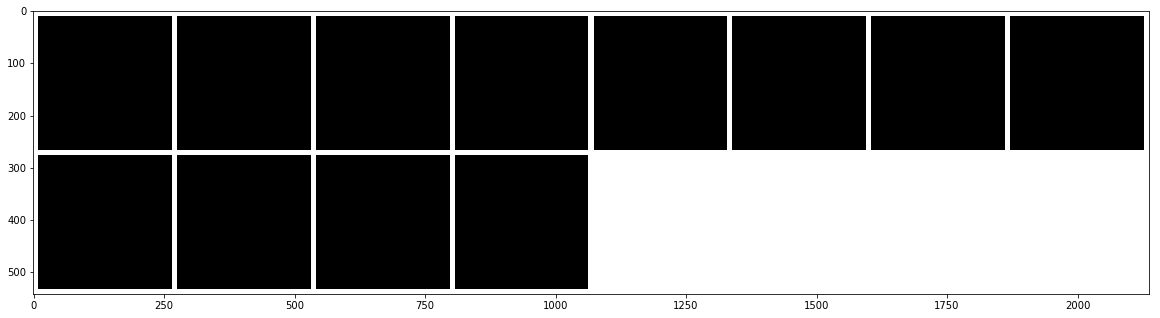

----------------------------------------------------------------------------------------------------
Prediction


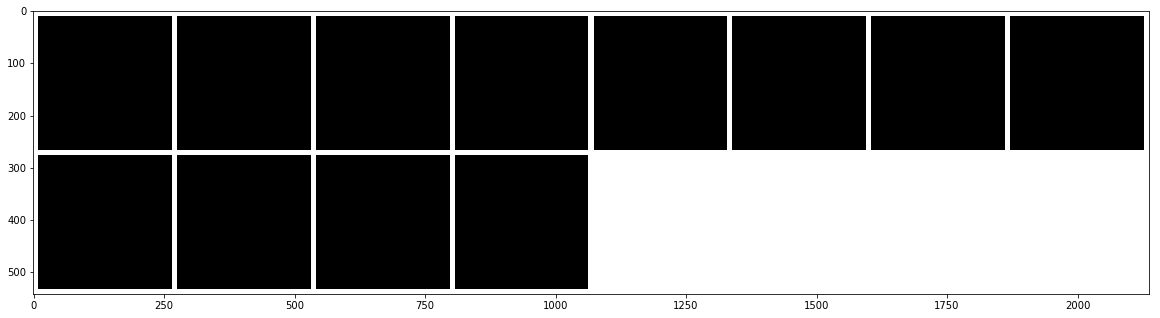

In [56]:
visualize_few()